In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
from io import StringIO as sio
try:
    import urllib2 as urllib
except ImportError:
    import urllib as urllib
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io
try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError
import ast
from censusAPI import myAPI
import json
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.cross_validation import train_test_split
from scipy.stats import chi2
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


success!


In [2]:
#make PUIDATA an environment variable if it isn't already
if os.getenv("PUIDATA") == None:
    os.environ["PUIDATA"] = "%s/PUIData"%os.getenv("HOME")

In [3]:
os.chdir(os.getenv("PUIDATA"))

## Part One: Data Gathering and Wrangling

### 1.1 Get Data on Schools and SATS

In [4]:
#link to open data
sat_url = 'https://data.cityofnewyork.us/resource/734v-jeq5.csv'

#read in data
sat = pd.read_csv(sat_url)
sat.to_csv('sat.csv')

#examine
sat.describe()

,dbn,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,school_name
count,478,478,478,478,478,478
unique,478,175,164,173,163,478
top,03M470,s,s,s,s,LANDMARK HIGH SCHOOL
freq,1,57,57,57,57,1


In [5]:
#get rid of the weird s rows
sat.drop(sat[sat.sat_critical_reading_avg_score == 's'].index, inplace=True)
sat.dtypes

#change numbers to numbers
num_cols = ['num_of_sat_test_takers','sat_critical_reading_avg_score','sat_math_avg_score',
           'sat_writing_avg_score']

sat[num_cols] = sat[num_cols].astype(int)
sat['dbn'] = sat.dbn.str.strip()

In [6]:
#check it out
sat.describe()

,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score
count,421.000000,421.000000,421.000000,421.000000
mean,110.320665,400.850356,413.368171,393.985748
std,155.534254,56.802783,64.684655,58.635109
min,6.000000,279.000000,312.000000,286.000000
25%,41.000000,368.000000,371.000000,360.000000
50%,62.000000,391.000000,395.000000,381.000000
75%,95.000000,416.000000,437.000000,411.000000
max,1277.000000,679.000000,735.000000,682.000000


In [7]:
#make average of three sat scores for each school
sat['overall_avg'] = sat[['sat_critical_reading_avg_score','sat_math_avg_score','sat_writing_avg_score']].mean(axis=1)

#just take columns of interest (school_id, math, overall)
sat = sat.loc[:,['dbn','sat_math_avg_score','overall_avg']]

In [8]:
#check it out
sat.describe()

,sat_math_avg_score,overall_avg
count,421.000000,421.000000
mean,413.368171,402.734759
std,64.684655,58.178708
min,312.000000,295.666667
25%,371.000000,367.333333
50%,395.000000,389.666667
75%,437.000000,419.000000
max,735.000000,698.666667


### 1.2 Get Data on Crimes in Schools 

In [9]:
#link to open data
crime_url = 'https://data.cityofnewyork.us/resource/sm8b-9vim.csv'

#read in data
crime = pd.read_csv(crime_url)

#examine
crime.head()

,address,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,bbl,bin,borough,borough_name,...,nta,oth_n,postcode,prop_n,rangea,register,school_year,schools,schools_in_building,vio_n
0,309 47 STREET,0.86,5.55,3.26,2.17,1.29,3.007550e+09,3011821.0,K,BROOKLYN,...,Sunset Park West ...,2.0,11220.0,1.0,1251-1500,"1,277",2013-14,1,P.S. 001 The Bergen,0.0
1,655 PARKSIDE AVENUE,NaN,NaN,NaN,NaN,NaN,3.050500e+09,3378201.0,K,BROOKLYN,...,Prospect Lefferts Gardens-Wingate ...,NaN,11226.0,NaN,251-500,479,2013-14,3,Parkside Preparatory Academy | P.S. K141 |Exp...,NaN
2,655 PARKSIDE AVENUE,NaN,NaN,NaN,NaN,NaN,3.050500e+09,3378201.0,K,BROOKLYN,...,Prospect Lefferts Gardens-Wingate ...,NaN,11226.0,NaN,251-500,397,2013-14,3,Parkside Preparatory Academy | P.S. K141 |Exp...,NaN
3,655 PARKSIDE AVENUE,NaN,NaN,NaN,NaN,NaN,3.050500e+09,3378201.0,K,BROOKLYN,...,Prospect Lefferts Gardens-Wingate ...,NaN,11226.0,NaN,NaN,NaN,2013-14,3,Parkside Preparatory Academy | P.S. K141 |Exp...,NaN
4,655 PARKSIDE AVENUE,0.52,2.49,1.71,1.16,0.75,3.050500e+09,3378201.0,K,BROOKLYN,...,Prospect Lefferts Gardens-Wingate ...,5.0,11226.0,2.0,751-1000,876,2013-14,3,Parkside Preparatory Academy | P.S. K141 |Exp...,4.0


In [10]:
#get all dbns associated with an address since if there are multiple dbns in one building
#the crime is only listed once in a row with no dbn.  
#whoever designed this is the absolute worst.  this is NOT HOW DATABASES WORK

#check to see if address is truly unique to location in case of addresses duplicated across boroughs
check = crime[['address','latitude','longitude']].groupby(['address','latitude','longitude']).count().reset_index()
check1 = check.groupby('address').count().reset_index()
check1[check1.sum(axis=1) > 2]

,address,latitude,longitude


In [11]:
crime.columns.values

array(['address', 'avgofmajor_n', 'avgofnocrim_n', 'avgofoth_n',
       'avgofprop_n', 'avgofvio_n', 'bbl', 'bin', 'borough',
       'borough_name', 'building_code', 'building_name', 'census_tract',
       'community_board', 'community_council', 'dbn', 'engroupa',
       'geographical_district_code', 'latitude', 'location_code',
       'location_name', 'longitude', 'major_n', 'nocrim_n', 'nta', 'oth_n',
       'postcode', 'prop_n', 'rangea', 'register', 'school_year',
       'schools', 'schools_in_building', 'vio_n'], dtype=object)

In [12]:
#make helper frame with one row per address with number of crimes
crime_cols = ['address','avgofmajor_n','avgofnocrim_n','avgofoth_n','avgofprop_n',
             'avgofvio_n','major_n','nocrim_n','oth_n','prop_n','vio_n']
address_crime = crime[crime.school_year == '2013-14'].loc[:,crime_cols]
address_crime.dropna(inplace=True, how='any')

In [13]:
#narrow down to columns of interest

#filter down to just 2013-2014, since it's the earliest available data close to 2012.
#ideally I think you'd want to look at the data for the years leading up to when students take the exam
#however, this is what we've got! so I'm making an assumption that school crime is steady year over year
crime = crime[crime['school_year'] == '2013-14']

cols_of_interest = ['address','dbn','latitude','longitude']
crime = crime.loc[:,cols_of_interest]

crime.dbn = crime.dbn.str.strip()
#join back helper column to get crime at location
crime = crime.merge(address_crime, on='address')

#drop rows with no dbn
crime.dropna(subset=['dbn'], inplace=True)

crime.head(10)

,address,dbn,latitude,longitude,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n
0,309 47 STREET,15K001,40.649042,-74.012289,0.86,5.55,3.26,2.17,1.29,0.0,1.0,2.0,1.0,0.0
1,655 PARKSIDE AVENUE,17K002,40.656183,-73.951583,0.52,2.49,1.71,1.16,0.75,1.0,2.0,5.0,2.0,4.0
2,655 PARKSIDE AVENUE,75K141,40.656183,-73.951583,0.52,2.49,1.71,1.16,0.75,1.0,2.0,5.0,2.0,4.0
3,655 PARKSIDE AVENUE,84K704,40.656183,-73.951583,0.52,2.49,1.71,1.16,0.75,1.0,2.0,5.0,2.0,4.0
5,50 JEFFERSON AVENUE,13K003,40.682663,-73.955338,0.33,1.76,1.32,0.83,0.59,2.0,0.0,0.0,2.0,0.0
6,820 HANCOCK STREET,16K005,40.685695,-73.922463,0.35,1.09,1.06,0.73,0.50,1.0,0.0,1.0,2.0,0.0
7,43 SNYDER AVENUE,17K006,40.648590,-73.957138,0.33,1.76,1.32,0.83,0.59,0.0,2.0,1.0,0.0,0.0
8,858 JAMAICA AVENUE,19K007,40.689697,-73.873109,0.56,3.56,2.40,1.36,1.05,0.0,0.0,1.0,0.0,0.0
9,37 HICKS STREET,13K008,40.700710,-73.993241,0.52,2.49,1.71,1.16,0.75,0.0,0.0,0.0,0.0,0.0
10,80 UNDERHILL AVENUE,13K009,40.678297,-73.965541,0.33,1.76,1.32,0.83,0.59,0.0,1.0,1.0,1.0,0.0


In [14]:
#clean up NaNs in columns of interest and drop rows with no dbn
crime.dropna(subset=['dbn'], inplace=True)
crime.fillna(0, inplace=True)
crime.describe()

,latitude,longitude,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,40.543958,-73.672321,0.520649,2.891049,1.951161,1.267928,0.847815,0.775281,4.121099,2.666667,1.883895,1.104869
std,2.488362,4.520102,0.359801,3.366913,1.597053,0.960454,0.660972,1.069784,6.778390,3.330165,2.409409,1.618329
min,0.000000,-74.040046,0.330000,1.090000,1.030000,0.730000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.656046,-73.977783,0.330000,1.090000,1.060000,0.730000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.681896,-73.948625,0.350000,1.760000,1.320000,0.830000,0.590000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,40.720581,-73.927973,0.520000,2.490000,1.710000,1.160000,0.750000,1.000000,4.000000,4.000000,3.000000,2.000000
max,40.867826,0.000000,2.930000,31.530000,12.330000,6.470000,5.130000,6.000000,37.000000,15.000000,14.000000,9.000000


#### Plot

Text(0.5,0,'Average Number of Major Crimes for Population Size of School')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


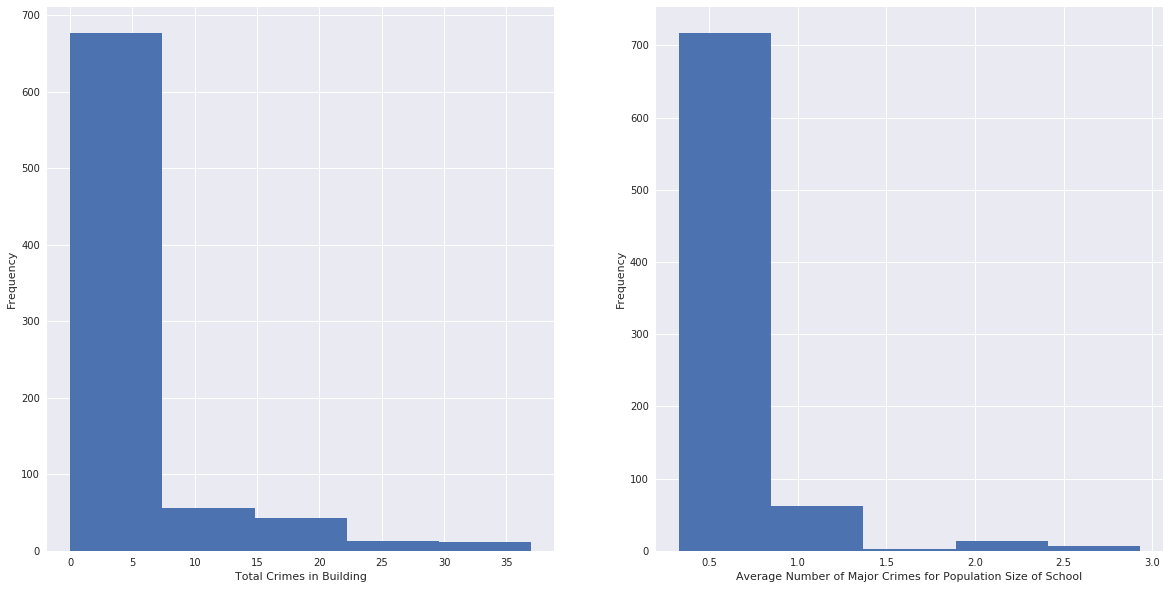

In [15]:
# plot with various axes scales
plt.figure(1, figsize=(20,10))

# math v total crime
plt.subplot(121)
plt.hist(crime.nocrim_n, bins=5)
plt.ylabel("Frequency")
plt.xlabel("Total Crimes in Building")

#histogram of avg major crime by school
plt.subplot(122)
plt.hist(crime.avgofmajor_n, bins=5)
plt.ylabel('Frequency')
plt.xlabel('Average Number of Major Crimes for Population Size of School')

Figure showing the distributions of the average number of major crimes by school size across city schools in the 2013-14 school year and the total number of crimes in the building.  The vast majority of school size ranges had between 0 and 0.6 average crimes in the 2013-14 school year and 0-7 total crimes.

## 2. Merge SAT and Crime Data together

### 2.1 Merge the SAT and the crime in school data based on the school identifier

In [16]:
#check out duplicate situation
print(sat.shape, crime.shape)
print(sat.dbn.describe(), crime.dbn.describe())
#neither dataset has duplicate DBNs

(421, 3) (801, 14)
count        421
unique       421
top       03M470
freq           1
Name: dbn, dtype: object count        801
unique       801
top       26Q188
freq           1
Name: dbn, dtype: object


In [17]:
sat_crime = pd.merge(sat, crime, on='dbn', how='left')
sat_crime.head()

,dbn,sat_math_avg_score,overall_avg,address,latitude,longitude,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n
0,01M292,404,374.000000,220 HENRY STREET,40.713684,-73.986336,0.33,1.76,1.32,0.83,0.59,4.0,9.0,15.0,14.0,5.0
1,01M448,423,390.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M450,402,383.000000,420 EAST 12 STREET,40.729589,-73.982555,0.33,1.76,1.32,0.83,0.59,1.0,0.0,4.0,3.0,1.0
3,01M458,401,391.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,433,402.333333,145 STANTON STREET,40.720581,-73.985645,0.56,3.56,2.40,1.36,1.05,0.0,10.0,7.0,3.0,4.0


In [18]:
sat_crime.shape
sat_crime.dbn.describe()
#421 schools with SAT scores.  We will assume if they are not in the crime data, that means they have zero crime.
#makes sense that crime data is much bigger since that data presumably includes elementary and middle schools

count        421
unique       421
top       03M470
freq           1
Name: dbn, dtype: object

### 2.2 Fill in the missing data as appropriate

In [19]:
#deal with missing data
sat_crime.isnull().sum()

dbn                     0
sat_math_avg_score      0
overall_avg             0
address               273
latitude              273
longitude             273
avgofmajor_n          273
avgofnocrim_n         273
avgofoth_n            273
avgofprop_n           273
avgofvio_n            273
major_n               273
nocrim_n              273
oth_n                 273
prop_n                273
vio_n                 273
dtype: int64

In [20]:
#grab lat/longs for every dbn from open data
#url = 'https://data.cityofnewyork.us/resource/2u2u-zka4.geojson'
#r = requests.get(url)
#data = r.json()
#school_locations = gpd.GeoDataFrame.from_features(data['features'])
#cols_of_interest = ['dbn','geometry']
#school_locations = school_locations.loc[:,cols_of_interest]
#school_locations.rename(columns={'ats_system_code':'dbn'}, inplace=True)
#school_locations['dbn'] = school_locations.dbn.str.strip()
#sat_crime = pd.merge(school_locations, sat_crime, on='dbn', how='right')

In [21]:
#try another source for lat/longs for every dbn from open data
url = 'https://data.cityofnewyork.us/download/jfju-ynrr/application%2Fzip'

#download the url
if os.path.isfile(os.getenv("PUIDATA") + "/Public_School_Locations.zip"):
    print("Data already there!")
else:
    urllib.request.urlretrieve(url, "Public_School_Locations.zip")
    os.system("unzip " + os.getenv("PUIDATA") + "/Public_School_Locations.zip")

Data already there!


In [22]:
#read in shapefile
shapefile = 'Public_Schools_Points_2011-2012A.shp'
school_points = gpd.GeoDataFrame.from_file(shapefile)
school_points.rename(columns={'ATS_CODE':'dbn'}, inplace=True)
cols_of_interest = ['dbn','geometry']
school_points = school_points.loc[:,cols_of_interest]

In [23]:
school_points.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [24]:
school_points = school_points.to_crs({'init': 'epsg:4326'}) 

In [25]:
school_points['dbn'] = school_points.dbn.str.strip()
sat_crime = pd.merge(school_points, sat_crime, on='dbn', how='right')
sat_crime.dropna(subset=['geometry'], inplace=True)

In [26]:
sat_crime.shape

(412, 17)

In [27]:
sat_crime.isnull().sum()

dbn                     0
geometry                0
sat_math_avg_score      0
overall_avg             0
address               265
latitude              265
longitude             265
avgofmajor_n          265
avgofnocrim_n         265
avgofoth_n            265
avgofprop_n           265
avgofvio_n            265
major_n               265
nocrim_n              265
oth_n                 265
prop_n                265
vio_n                 265
dtype: int64

In [28]:
#deal with and coalesce lat/long situation
#sat_crime['latlong'] = list(zip(sat_crime['longitude'], sat_crime['latitude']))

# Create Point Geometry based on lonlat column
#sat_crime['geometry2'] = sat_crime[['latlong']].applymap(lambda x: shapely.geometry.Point(x))

#sat_crime['geometry'] = sat_crime.geometry.combine_first(sat_crime.geometry2)

#sat_crime.to_crs(epsg=4326)
#sat_crime.to_crs(epsg=2263, inplace=True)

#sat_crime.drop(axis=1, labels=['geometry2','latitude','longitude'], inplace=True)


In [29]:
sat_crime['x'] = sat_crime.geometry.x
sat_crime['y'] = sat_crime.geometry.y

#fill missing crime with zeros since if it's not in the database, it means no crime.
sat_crime[crime_cols] = sat_crime[crime_cols].fillna(0)

unique_locations = sat_crime[['x','y']].groupby(['x','y']).count().reset_index()
unique_locations['xy'] = unique_locations.x + unique_locations.y

### 2.3 Count the individual school locations

In [30]:
#Check out total number of schools at each unique locations
print("Total Schools:",len(sat_crime))
print("Total Locations:", unique_locations['xy'].nunique())

#multiple schools at one location, but only crime data for one location!
#this will matter later when we're aggregating--don't want to accidently multiply crime!

Total Schools: 412
Total Locations: 408


## 3. Visualize the school related data

### 3.1 Plot math SAT and average SAT against # of major crimes and average crimes

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


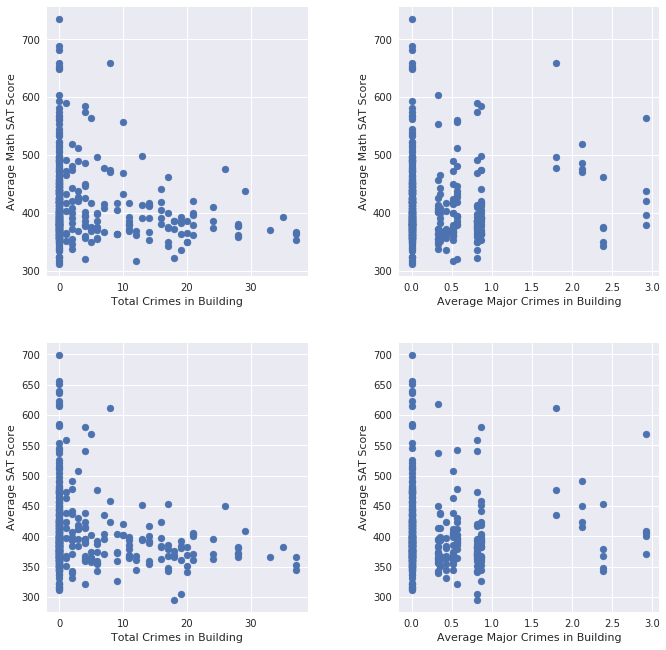

In [31]:
math_sat = sat_crime.sat_math_avg_score
avg_sat = sat_crime.overall_avg
major_n = sat_crime.nocrim_n
avg_c = sat_crime.avgofmajor_n

# plot with various axes scales
plt.figure(1, figsize=(10,10))

# math v total crime
plt.subplot(221)
plt.scatter(major_n, math_sat)
plt.ylabel("Average Math SAT Score")
plt.xlabel("Total Crimes in Building")

# math v avg crime
plt.subplot(222)
plt.scatter(avg_c, math_sat)
plt.ylabel("Average Math SAT Score")
plt.xlabel("Average Major Crimes in Building")

# avg v total
plt.subplot(223)
plt.scatter(major_n, avg_sat)
plt.ylabel("Average SAT Score")
plt.xlabel("Total Crimes in Building")

# avg v avg
plt.subplot(224)
plt.scatter(avg_c, avg_sat)
plt.ylabel("Average SAT Score")
plt.xlabel("Average Major Crimes in Building")

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

Figure showing four different scatter plots of total crime in building, average major crime in schools of the same size, average SAT score, average math SAT score.  There looks to be some relationship between total crimes in the building and both kinds of SAT scores.  The relationship between average crime in that size of building and scores is less clear.

### 3.2 Make geometry for lat/long of school and map school locations

In [32]:
borough_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'
#download the url
if os.path.isfile(os.getenv("PUIDATA") + "/Borough Boundaries.geojson"):
    print("Data already there!")
else:
    urllib.request.urlretrieve(borough_url, "Borough Boundaries.geojson")

Data already there!


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


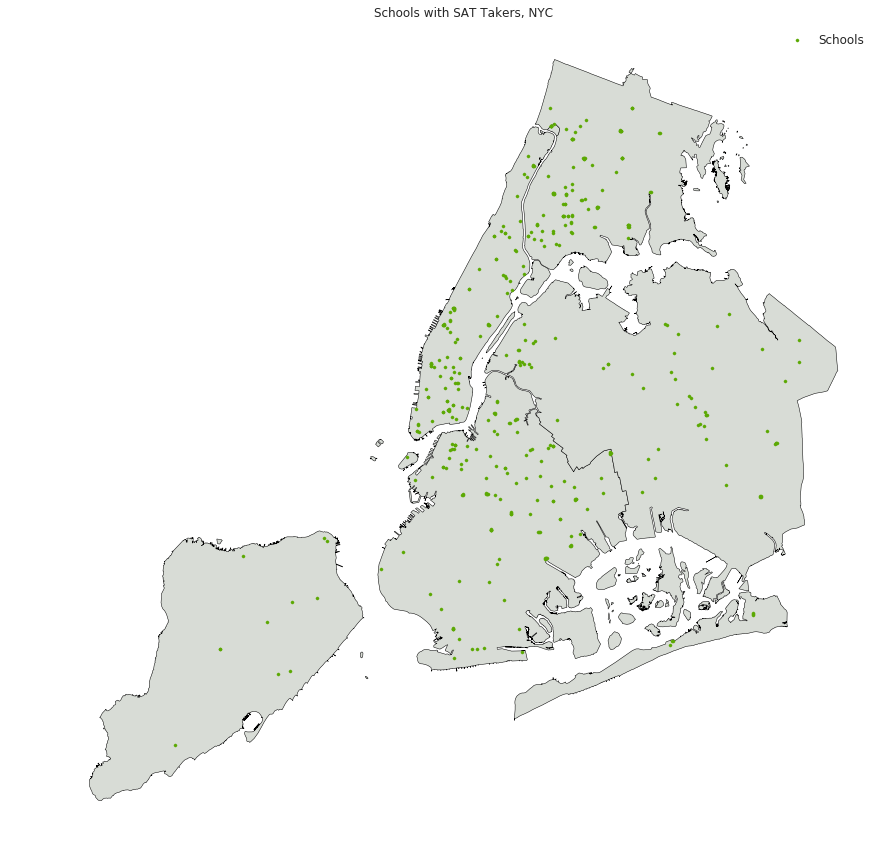

In [33]:
#note I did the making geometry thing earlier when incorporating the additional address data from OpenData.
#but I'm recopying the cell here in comment version!

# Create Point Geometry based on lonlat column
#sat_crime['geometry2'] = sat_crime[['latlong']].applymap(lambda x: shapely.geometry.Point(x))

boroughs = gpd.read_file("Borough Boundaries.geojson")

fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Schools with SAT Takers, NYC")
boroughs.to_crs(epsg=2263).plot(ax=ax, color='xkcd:light grey', edgecolor='black', lw=0.5)
sat_crime.to_crs(epsg=2263).plot(ax=ax, marker='o', c="xkcd:leaf green", markersize=10)
plt.legend(['Schools'], loc=0, fontsize='large')
plt.show()


Figure showing the location of New York City schools where students took the SAT in 2012.

## 4. Gather asthma and drugs hospital discharge data

#### 4.1 Read in SPARCS data for 5 boroughs

In [34]:
#links to data
bx_sparcs = 'https://health.data.ny.gov/resource/rv8x-4fm3.csv?hospital_county=Bronx&$limit=50000&$order=:id&$offset='
bk_sparcs = 'https://health.data.ny.gov/resource/rv8x-4fm3.csv?hospital_county=Kings&$limit=50000&$order=:id&$offset='
mn_sparcs = 'https://health.data.ny.gov/resource/rv8x-4fm3.csv?hospital_county=Manhattan&$limit=50000&$order=:id&$offset='
si_sparcs = 'https://health.data.ny.gov/resource/rv8x-4fm3.csv?hospital_county=Richmond&$limit=50000&$order=:id&$offset='
qn_sparcs = 'https://health.data.ny.gov/resource/rv8x-4fm3.csv?hospital_county=Queens&$limit=50000&$order=:id&$offset='

all_counties = [bx_sparcs, bk_sparcs, mn_sparcs, si_sparcs, qn_sparcs]
offset_length = [4,6,9,2,5]

offsets = [0, 50000, 10000, 150000, 200000, 250000, 300000, 350000, 400000]

#make api_calls
all_calls = []

for county, offset in zip(all_counties, offset_length):
    all_off = offsets[0:offset]
    for off in all_off:
        call = county + str(off)
        all_calls.append(call)

In [35]:
#Commenting this out and relying on loading csv for kernel restart purposes
dfs = []
#read in data
for call in all_calls:
    sparcs = pd.read_csv(call)
    dfs.append(sparcs)

#download for kernel restarts
#sparcs.to_csv('nyc_sparcs.csv')

In [36]:
#concatenate all the dataframes together
sparcs = pd.concat(dfs)

#read from PUIDATA for kernel restarting purposes
#sparcs = pd.read_csv('nyc_sparcs.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
#check it out
sparcs.head()

,Unnamed: 0,abortion_edit_indicator,age_group,apr_drg_code,apr_drg_description,apr_mdc_code,apr_mdc_description,apr_medical_surgical_description,apr_risk_of_mortality,apr_severity_of_illness_code,...,source_of_payment_1,source_of_payment_2,source_of_payment_3,total_charges,total_costs,type_of_admission,zip_code_3_digits,asthma_flag,drug_flag,all_flag
0,0,N,0 to 17,141,Asthma,4,Diseases and Disorders of the Respiratory System,Medical,Minor,1,...,Medicaid,Medicaid,NaN,10408.87,8618.38,Emergency,104,1,0,1
1,1,N,50 to 69,141,Asthma,4,Diseases and Disorders of the Respiratory System,Medical,Minor,1,...,Medicaid,NaN,NaN,4652.69,3852.35,Emergency,104,1,0,1
2,2,N,30 to 49,141,Asthma,4,Diseases and Disorders of the Respiratory System,Medical,Minor,2,...,Medicaid,Medicaid,NaN,4044.20,3348.53,Emergency,104,1,0,1
3,3,N,0 to 17,141,Asthma,4,Diseases and Disorders of the Respiratory System,Medical,Minor,2,...,Medicaid,Medicaid,NaN,9130.51,7559.92,Emergency,104,1,0,1
4,4,N,50 to 69,203,Chest pain,5,Diseases and Disorders of the Circulatory System,Medical,Minor,1,...,Self-Pay,NaN,NaN,4171.46,3453.90,Emergency,104,0,0,1


#### 4.2 Calculate fraction fo asthma and drug related diagnoses per facility.

In [38]:
asthma_diagnoses = ['Asthma','Other upper respiratory disease','Acute bronchitis',
                   'Respiratory distress syndrome','Respiratory failure; insufficiency; arrest (adult)',
                   'Other upper respiratory infections','Other lower respiratory infections']
drug_diagnoses = ['Alcohol-related disorders','Poisoning by other medications and drugs',
                  'Poisoning by nonmedicinal substances','Poisoning by psychotropic agents',
                 'Substance-related disorders','Screening and history of mental health and substance abuse codes']

In [39]:
print("Total Discharges:", len(sparcs))
print("Number of Facilities:", sparcs.facility_id.nunique())
print("Number of Asthma Related Cases:", len(sparcs[sparcs.ccs_diagnosis_description.isin(asthma_diagnoses)]))
print("Number of Substance Related Cases:", len(sparcs[sparcs.ccs_diagnosis_description.isin(drug_diagnoses)]))

Total Discharges: 1199520
Number of Facilities: 55
Number of Asthma Related Cases: 44176
Number of Substance Related Cases: 59562


In [40]:
sparcs['asthma_flag'] = np.where(sparcs.ccs_diagnosis_description.isin(asthma_diagnoses), 1,0)
sparcs['drug_flag'] = np.where(sparcs.ccs_diagnosis_description.isin(drug_diagnoses), 1,0)
sparcs['all_flag'] = 1

In [41]:
facility_ratio = sparcs[['facility_id','asthma_flag','drug_flag','all_flag']].groupby('facility_id').sum().reset_index()

In [42]:
facility_ratio['asthma_ratio'] = facility_ratio.asthma_flag / facility_ratio.all_flag
facility_ratio['drug_ratio'] = facility_ratio.drug_flag / facility_ratio.all_flag

In [43]:
facility_ratio.head()

,facility_id,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio
0,1164,0,2391,4917,0.000000,0.486272
1,1165,2393,2660,36829,0.064976,0.072226
2,1168,1454,2202,31778,0.045755,0.069293
3,1169,4357,940,61828,0.070470,0.015203
4,1172,1419,717,14648,0.096873,0.048949


Text(0,0.5,'Frequency')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


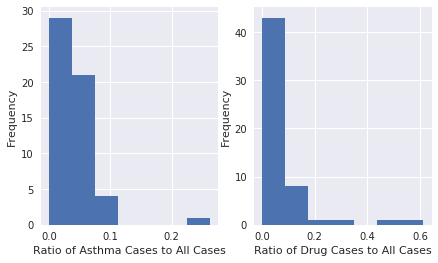

In [44]:
# plot with various axes scales
plt.figure(1, figsize=(7,4))

# math v total crime
plt.subplot(121)
plt.hist(facility_ratio.asthma_ratio, bins=7)
plt.xlabel("Ratio of Asthma Cases to All Cases")
plt.ylabel("Frequency")

# math v avg crime
plt.subplot(122)
plt.hist(facility_ratio.drug_ratio, bins=7)
plt.xlabel("Ratio of Drug Cases to All Cases")
plt.ylabel("Frequency")


Figure showing the distribution of asthma and drug ratios across all facilities.  Note that for drug cases, there are a handful of facilities where over 50% of their cases are drug related.

#### 4.3 Get location of each facility

In [45]:
api_endpoint = 'https://fb55.carto.com:443/api/v2/sql?q='

In [46]:
#define functions
def queryCartoDB(query, formatting = 'CSV', source = api_endpoint):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [47]:
query = '''SELECT facility_id, facility_latitude, facility_longitude FROM fb55.nyc_facilities;'''

In [48]:
facility_location = get_data(query)
facility_location['latlong'] = list(zip(facility_location['facility_longitude'], 
                                        facility_location['facility_latitude']))
facility_location['geometry'] = facility_location[['latlong']].applymap(lambda x: shapely.geometry.Point(x))
facility_location = gpd.GeoDataFrame(facility_location, geometry='geometry')
facility_location.crs = {'init':'epsg:4326'}
facility_location.to_crs(epsg=2263, inplace=True)

In [49]:
facility_location = pd.merge(facility_location, facility_ratio, on='facility_id')

facility_location.head()

,facility_id,facility_latitude,facility_longitude,latlong,geometry,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio
0,1320,40.654518,-73.945045,"(-73.945045, 40.654518)",POINT (999498.3625009272 177739.7234582751),840,184,16928,0.049622,0.010870
1,1445,40.814350,-73.940506,"(-73.940506, 40.81435)",POINT (1000718.248827583 235972.3702190958),647,1400,11918,0.054288,0.117469
2,1486,40.802979,-73.940811,"(-73.940811, 40.802979)",POINT (1000636.622561311 231829.4553145666),128,1,486,0.263374,0.002058
3,1309,40.677940,-73.937515,"(-73.937515, 40.67794)",POINT (1001581.624099063 186274.4175807593),581,1891,10658,0.054513,0.177425
4,1164,40.831772,-73.903656,"(-73.903656, 40.831772)",POINT (1010911.53600715 242328.9072250157),0,2391,4917,0.000000,0.486272


## 5. Aggregate at the PUMA level

#### 5.1 Get PUMA geodata

In [50]:
puma_download = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

In [51]:
#download the url
if os.path.isfile(os.getenv("PUIDATA") + "/puma_shapes.zip"):
    print("Data already there!")
else:
    urllib.request.urlretrieve(puma_download, "puma_shapes.zip")
    os.system("unzip " + os.getenv("PUIDATA") + "/puma_shapes.zip")

Data already there!


In [52]:
#read in shapefile
shapefile = 'geo_export_d0564880-391d-4f7c-9314-650d8a5dfd03.shp'
puma_shapes = gpd.GeoDataFrame.from_file(shapefile)
puma_shapes.to_crs(epsg=2263, inplace=True)

In [53]:
sat_crime.to_crs(epsg=2263, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


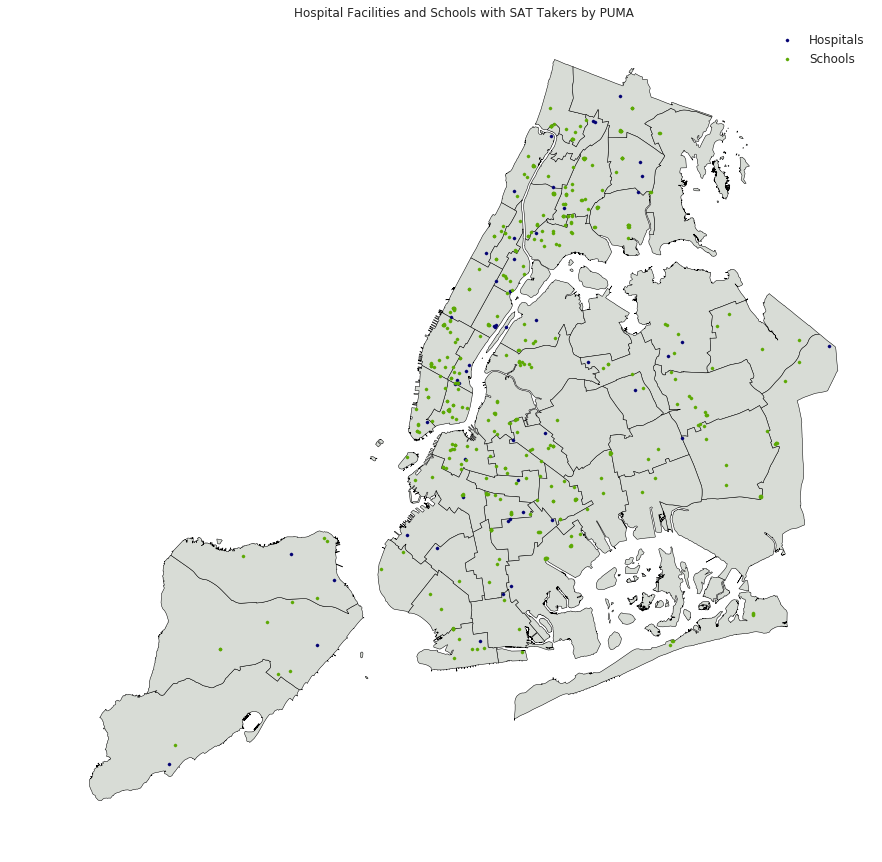

In [54]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Hospital Facilities and Schools with SAT Takers by PUMA")
puma_shapes.plot(ax=ax, color='xkcd:light grey', edgecolor='black', lw=0.5)
facility_location.plot(ax=ax, marker='o', c="xkcd:deep blue", markersize=10)
sat_crime.plot(ax=ax, marker='o', c="xkcd:leaf green", markersize=10)
plt.legend(['Hospitals','Schools'], loc=0, fontsize='large')
plt.show()

#### 5.2 Join hospital data and PUMAs

In [55]:
#spatial join to get PUMA id for each facility
puma_hospital = gpd.sjoin(facility_location, puma_shapes, how='left')

In [56]:
#while the instructions say to take average of the facility ratios, I think the better thing
#is to take the ratio for the total asthma and drug cases in the puma.

#the reason I think this is preferable is that especially for drug/alcohol use, there are facilities
#where that is a specialty.  Consider a PUMA with two facilities, one with 10 cases of drugs out of 1000,
#and one with 9 cases of drugs out of 10.  If we average the ratios, we're going to say whoa! 0.46!

#however, if we instead look at as 19 cases out of 1100, it's 0.02.  I would argue that this is the more accurate
#representation of the prevalence of the issue across the population of the PUMA, unbiased by specialty centers.

puma_health = puma_hospital.groupby('puma')['asthma_flag','drug_flag','all_flag'].sum().reset_index()

puma_health['asthma_ratio'] = puma_health.asthma_flag / puma_health.all_flag
puma_health['drug_ratio'] = puma_health.drug_flag / puma_health.all_flag

puma_health.head()

,puma,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio
0,3702,1454,2202,31778,0.045755,0.069293
1,3704,3037,2871,63929,0.047506,0.044909
2,3705,0,2391,4917,0.000000,0.486272
3,3706,4640,1254,70557,0.065762,0.017773
4,3707,641,237,7030,0.091181,0.033713


#### 5.3 Join school data and PUMAs

In [57]:
#spatial join to get PUMA id for each school
puma_school = gpd.sjoin(sat_crime, puma_shapes, how='left')

In [58]:
puma_school.head()

,dbn,geometry,sat_math_avg_score,overall_avg,address,latitude,longitude,avgofmajor_n,avgofnocrim_n,avgofoth_n,...,nocrim_n,oth_n,prop_n,vio_n,x,y,index_right,puma,shape_area,shape_leng
0,13K265,POINT (990919.368230822 193124.3821889274),349,358.000000,101 PARK AVENUE,40.696324,-73.975780,0.33,1.76,1.32,...,5.0,3.0,3.0,0.0,-73.975948,40.696756,32,4004,8.663744e+07,73144.345090
1,13K336,POINT (999249.7091512417 187711.8446447493),374,410.333333,0,NaN,NaN,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,-73.945919,40.681890,31,4003,6.403672e+07,44724.499267
2,21K344,POINT (992045.3281507798 151424.069099309),427,412.333333,521 WEST AVENUE,40.582533,-73.973132,0.56,3.56,2.40,...,3.0,6.0,6.0,0.0,-73.971936,40.582297,39,4018,9.604206e+07,76218.368926
3,21K348,POINT (988157.0246159214 155688.0576785965),398,388.000000,2630 BENSON AVENUE,40.594291,-73.985770,0.81,8.48,5.43,...,6.0,8.0,8.0,0.0,-73.985932,40.594003,39,4018,9.604206e+07,76218.368926
4,13K350,POINT (988477.2847751931 193373.5391480712),364,360.000000,49 FLATBUSH AVENUE EXTENSION,40.697339,-73.985016,0.86,5.55,3.26,...,9.0,9.0,5.0,4.0,-73.984755,40.697441,32,4004,8.663744e+07,73144.345090


In [59]:
crime_cols.remove('address')
crime_cols.extend(('sat_math_avg_score','overall_avg'))
puma_school_crime = puma_school.groupby('puma')[crime_cols].mean().reset_index()

In [60]:
puma_school_crime.head(15)

,puma,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n,sat_math_avg_score,overall_avg
0,3701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,423.470588,410.627451
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,399.750000,390.250000
3,3704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,412.666667,404.611111
4,3705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,379.076923,374.884615
5,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333
6,3708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,382.384615,377.384615
7,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,371.923077,366.128205
8,3710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,380.437500,374.791667
9,3801,0.140000,0.890000,0.600000,0.340000,0.262500,0.000000,1.000000,0.875000,0.375000,0.375000,391.250000,379.750000


In [61]:
puma_school.shape, puma_hospital.shape

((412, 23), (52, 14))

In [62]:
pumas = pd.DataFrame(puma_shapes.puma.values)
pumas.rename(columns={0:'puma'}, inplace=True)

In [63]:
final_data = pd.merge(pumas, puma_school_crime, how='inner', on='puma')
final_data = pd.merge(final_data, puma_health, how='inner', on='puma')

In [64]:
final_data.head()

,puma,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n,sat_math_avg_score,overall_avg,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio
0,3702,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,378.555556,374.740741,1454,2202,31778,0.045755,0.069293
1,3704,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,412.666667,404.611111,3037,2871,63929,0.047506,0.044909
2,4016,1.183333,7.87,4.906667,3.196667,1.966667,1.333333,20.333333,7.333333,4.0,3.0,476.000000,458.000000,624,174,15136,0.041226,0.011496
3,3705,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,379.076923,374.884615,0,2391,4917,0.000000,0.486272
4,3707,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,365.000000,356.833333,641,237,7030,0.091181,0.033713


In [65]:
final_data.shape

(34, 18)

## Extra Credit: Add income data from ACS

To complete this section, you need to have a file called "CensusAPI.py" in the same directory as this file with a variable named "myAPI" set equal to your census API key.

e.g. myAPI = 'xjfjrijsidjfjklkjfjfjfj'

In [66]:
#read in in the variables available. the info you need is in the 1 year ACS data
url = "https://api.census.gov/data/2012/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff5y = json.loads(resp.text)

In [67]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff5y['variables'].keys()))

In [68]:
#find the income keys
[(k, aff5y['variables'][k]['label'])  for k in affkeys if k.startswith ("B19113G_001E")]

[('B19113G_001E',
  'Estimate!!Median family income in the past 12 months (in 2012 inflation-adjusted dollars)')]

In [69]:
#keyword for the number of households
keyincome = 'B19113G_001E'
aff5y['variables'][keyincome]

{'attributes': 'B19113G_001EA,B19113G_001M,B19113G_001MA',
 'group': 'B19113G',
 'label': 'Estimate!!Median family income in the past 12 months (in 2012 inflation-adjusted dollars)',
 'limit': 0,
 'predicateType': 'int'}

In [70]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2012/acs/acs5?get=" + keyincome +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
puma_income = pd.read_csv(sio(resp.decode('utf-8').replace('[','').replace(']','')))

puma_income.head()

,B19113G_001E,NAME,state,public use microdata area,Unnamed: 4
0,89688,"Putnam County PUMA, New York",36,3101,NaN
1,99615,"Westchester County (Northwest) PUMA, New York",36,3102,NaN
2,132619,"Westchester County (Northeast) PUMA, New York",36,3103,NaN
3,35263,"Westchester County (Southeast) PUMA, New York",36,3104,NaN
4,86836,Westchester County (Central)--White Plains Cit...,36,3105,NaN


In [71]:
puma_income.rename(columns={'B19113G_001E':'median_income', 'public use microdata area':'puma'},
                  inplace=True)
puma_income.head()
puma_income = puma_income.loc[:,['puma','median_income']]
puma_income['puma'] = puma_income.astype(str)

In [72]:
final_data = pd.merge(final_data, puma_income, on='puma', how='left')

In [73]:
final_data.head()

,puma,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n,sat_math_avg_score,overall_avg,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio,median_income
0,3702,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,378.555556,374.740741,1454,2202,31778,0.045755,0.069293,62647
1,3704,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,412.666667,404.611111,3037,2871,63929,0.047506,0.044909,37568
2,4016,1.183333,7.87,4.906667,3.196667,1.966667,1.333333,20.333333,7.333333,4.0,3.0,476.000000,458.000000,624,174,15136,0.041226,0.011496,36971
3,3705,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,379.076923,374.884615,0,2391,4917,0.000000,0.486272,25475
4,3707,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,365.000000,356.833333,641,237,7030,0.091181,0.033713,31719


In [74]:
#add geometry for plotting purposes
final_data_g = pd.merge(puma_shapes, final_data, on='puma', how='inner')

# Part Two: Visual and Exploratory Analysis and Modeling

## 6. Check collinearity and covariance

#### 6.1 Plot SAT features against each other and assess collinearity

Text(0,0.5,'Average Overall SAT Score by PUMA')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


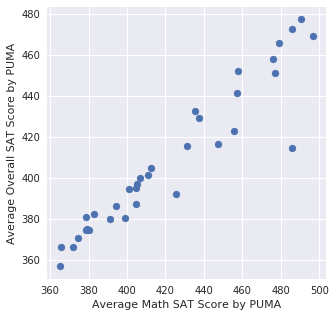

In [75]:
# plot with various axes scales
plt.figure(1, figsize=(5,5))

# math sat vs all sat
plt.scatter(final_data.sat_math_avg_score, final_data.overall_avg)
plt.xlabel("Average Math SAT Score by PUMA")
plt.ylabel("Average Overall SAT Score by PUMA")

Figure showing the average Math SAT score by PUMA plotted against the overall average SAT Score by PUMA.  Unsurprisingly, these feature appear to be highly linearly correlated--the higher the score on the math section, the higher the score overall.  This means we should only include one of these variables in our model, since one will very highly predict the other.

#### 6.2 Plot the SAT feature by PUMA against 3 of the crime features

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


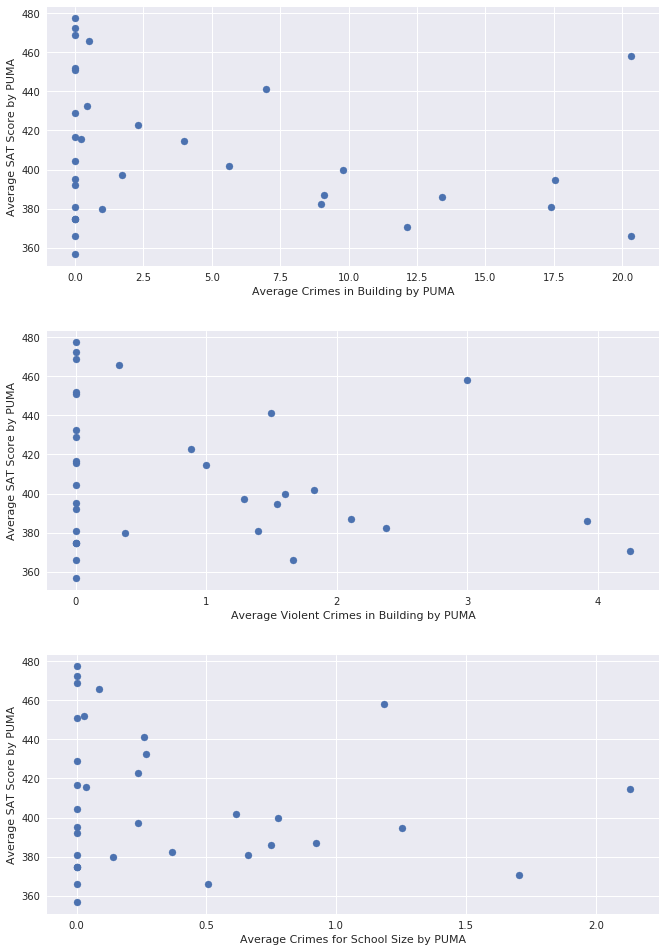

In [76]:
avg_sat = final_data.overall_avg
total_n = final_data.nocrim_n
avg_c = final_data.avgofmajor_n
vio_n = final_data.vio_n


# plot with various axes scales
plt.figure(1, figsize=(10,15))

# math v total crime
plt.subplot(311)
plt.scatter(total_n, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Average Crimes in Building by PUMA")

# math v avg crime
plt.subplot(312)
plt.scatter(vio_n, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Average Violent Crimes in Building by PUMA")

# avg v total
plt.subplot(313)
plt.scatter(avg_c, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Average Crimes for School Size by PUMA")

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

Figure showing the average SAT score by PUMA against three different measures of crime in schools by PUMA, the average total crimes, the average total violent crimes, and the average of the crimes by school size.  It looks like there is a negative linear correlation between SAT scores and each of the three crime measures, with the strongest looking relationship between SAT score and average of total crime.  All three variables have the same general negative linear relationship with SAT scores.

#### 6.3 Plot the medical data against SAT scores.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


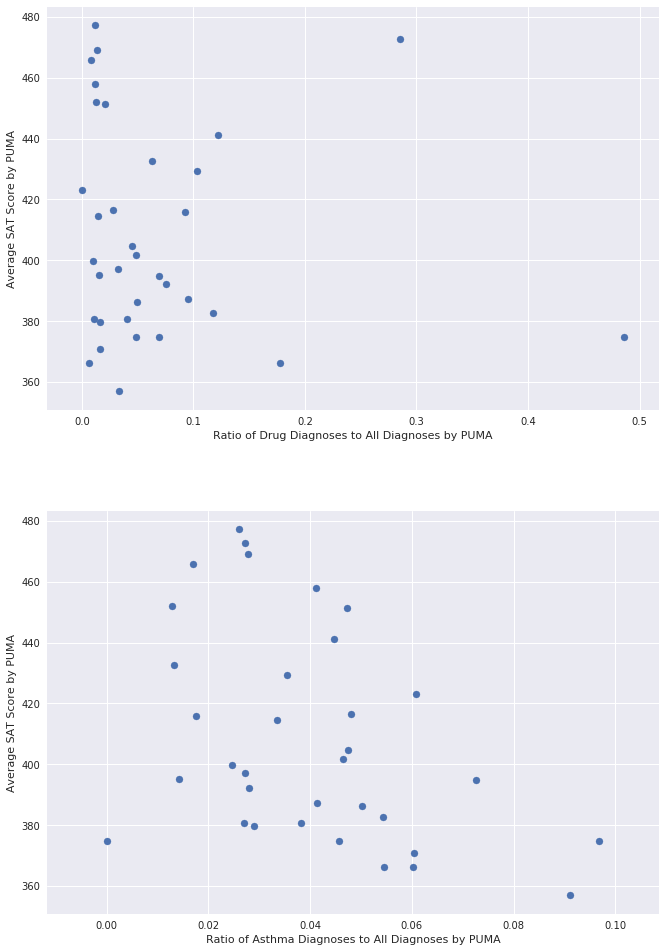

In [77]:
avg_sat = final_data.overall_avg
drug = final_data.drug_ratio
asthma = final_data.asthma_ratio

# plot with various axes scales
plt.figure(1, figsize=(10,15))

# math v total crime
plt.subplot(211)
plt.scatter(drug, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Ratio of Drug Diagnoses to All Diagnoses by PUMA")

# math v avg crime
plt.subplot(212)
plt.scatter(asthma, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Ratio of Asthma Diagnoses to All Diagnoses by PUMA")


# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

Figure showing the relationship between the ratio of drug and asthma diagnoses to all diagnoses and average SAT score by PUMA.  Neither variable appears to have a super strong linear relationship.

#### 6.3.2 Plot income against SAT scores

Text(0.5,0,'Median Income by PUMA')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


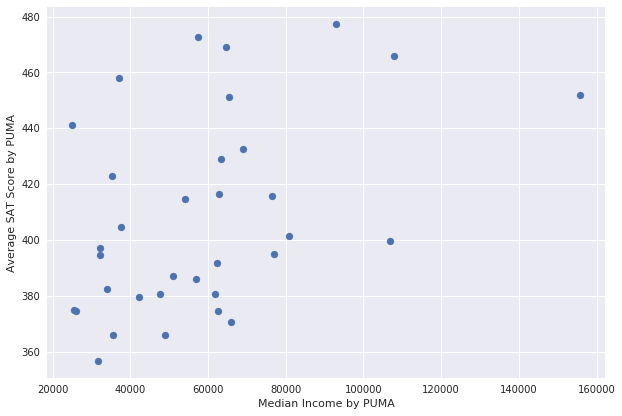

In [78]:
avg_sat = final_data.overall_avg
income = final_data.median_income

# plot with various axes scales
plt.figure(1, figsize=(10,15))

# math v total crime
plt.subplot(211)
plt.scatter(income, avg_sat)
plt.ylabel("Average SAT Score by PUMA")
plt.xlabel("Median Income by PUMA")

Figure showing the median income for a PUMA against the average SAT score in that PUMA.  Somewhat surprisingly, this appears to be the least correlated of the variables we've examined.

#### Extra Credit: Covariance Matrix

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


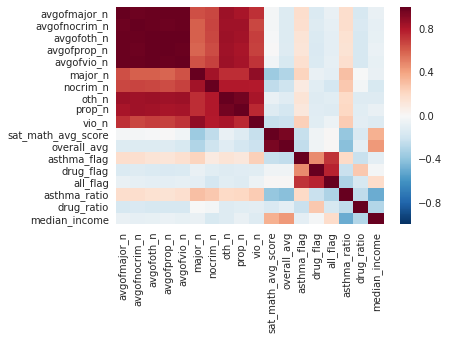

In [79]:
corr = final_data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

The covariance matrix shows that all 10 crime features are highly correlated with each other, as well as the SAT scores (which we knew from our earlier visualization), as well as the health indicators.  Other hotspots of covariance are median income and overall average SAT score.

## 7. Mapping

-  the SAT features,
-  the 3 chosen school crime features
-  the two medical discharge features
-  the income if you have it from the extra credit

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


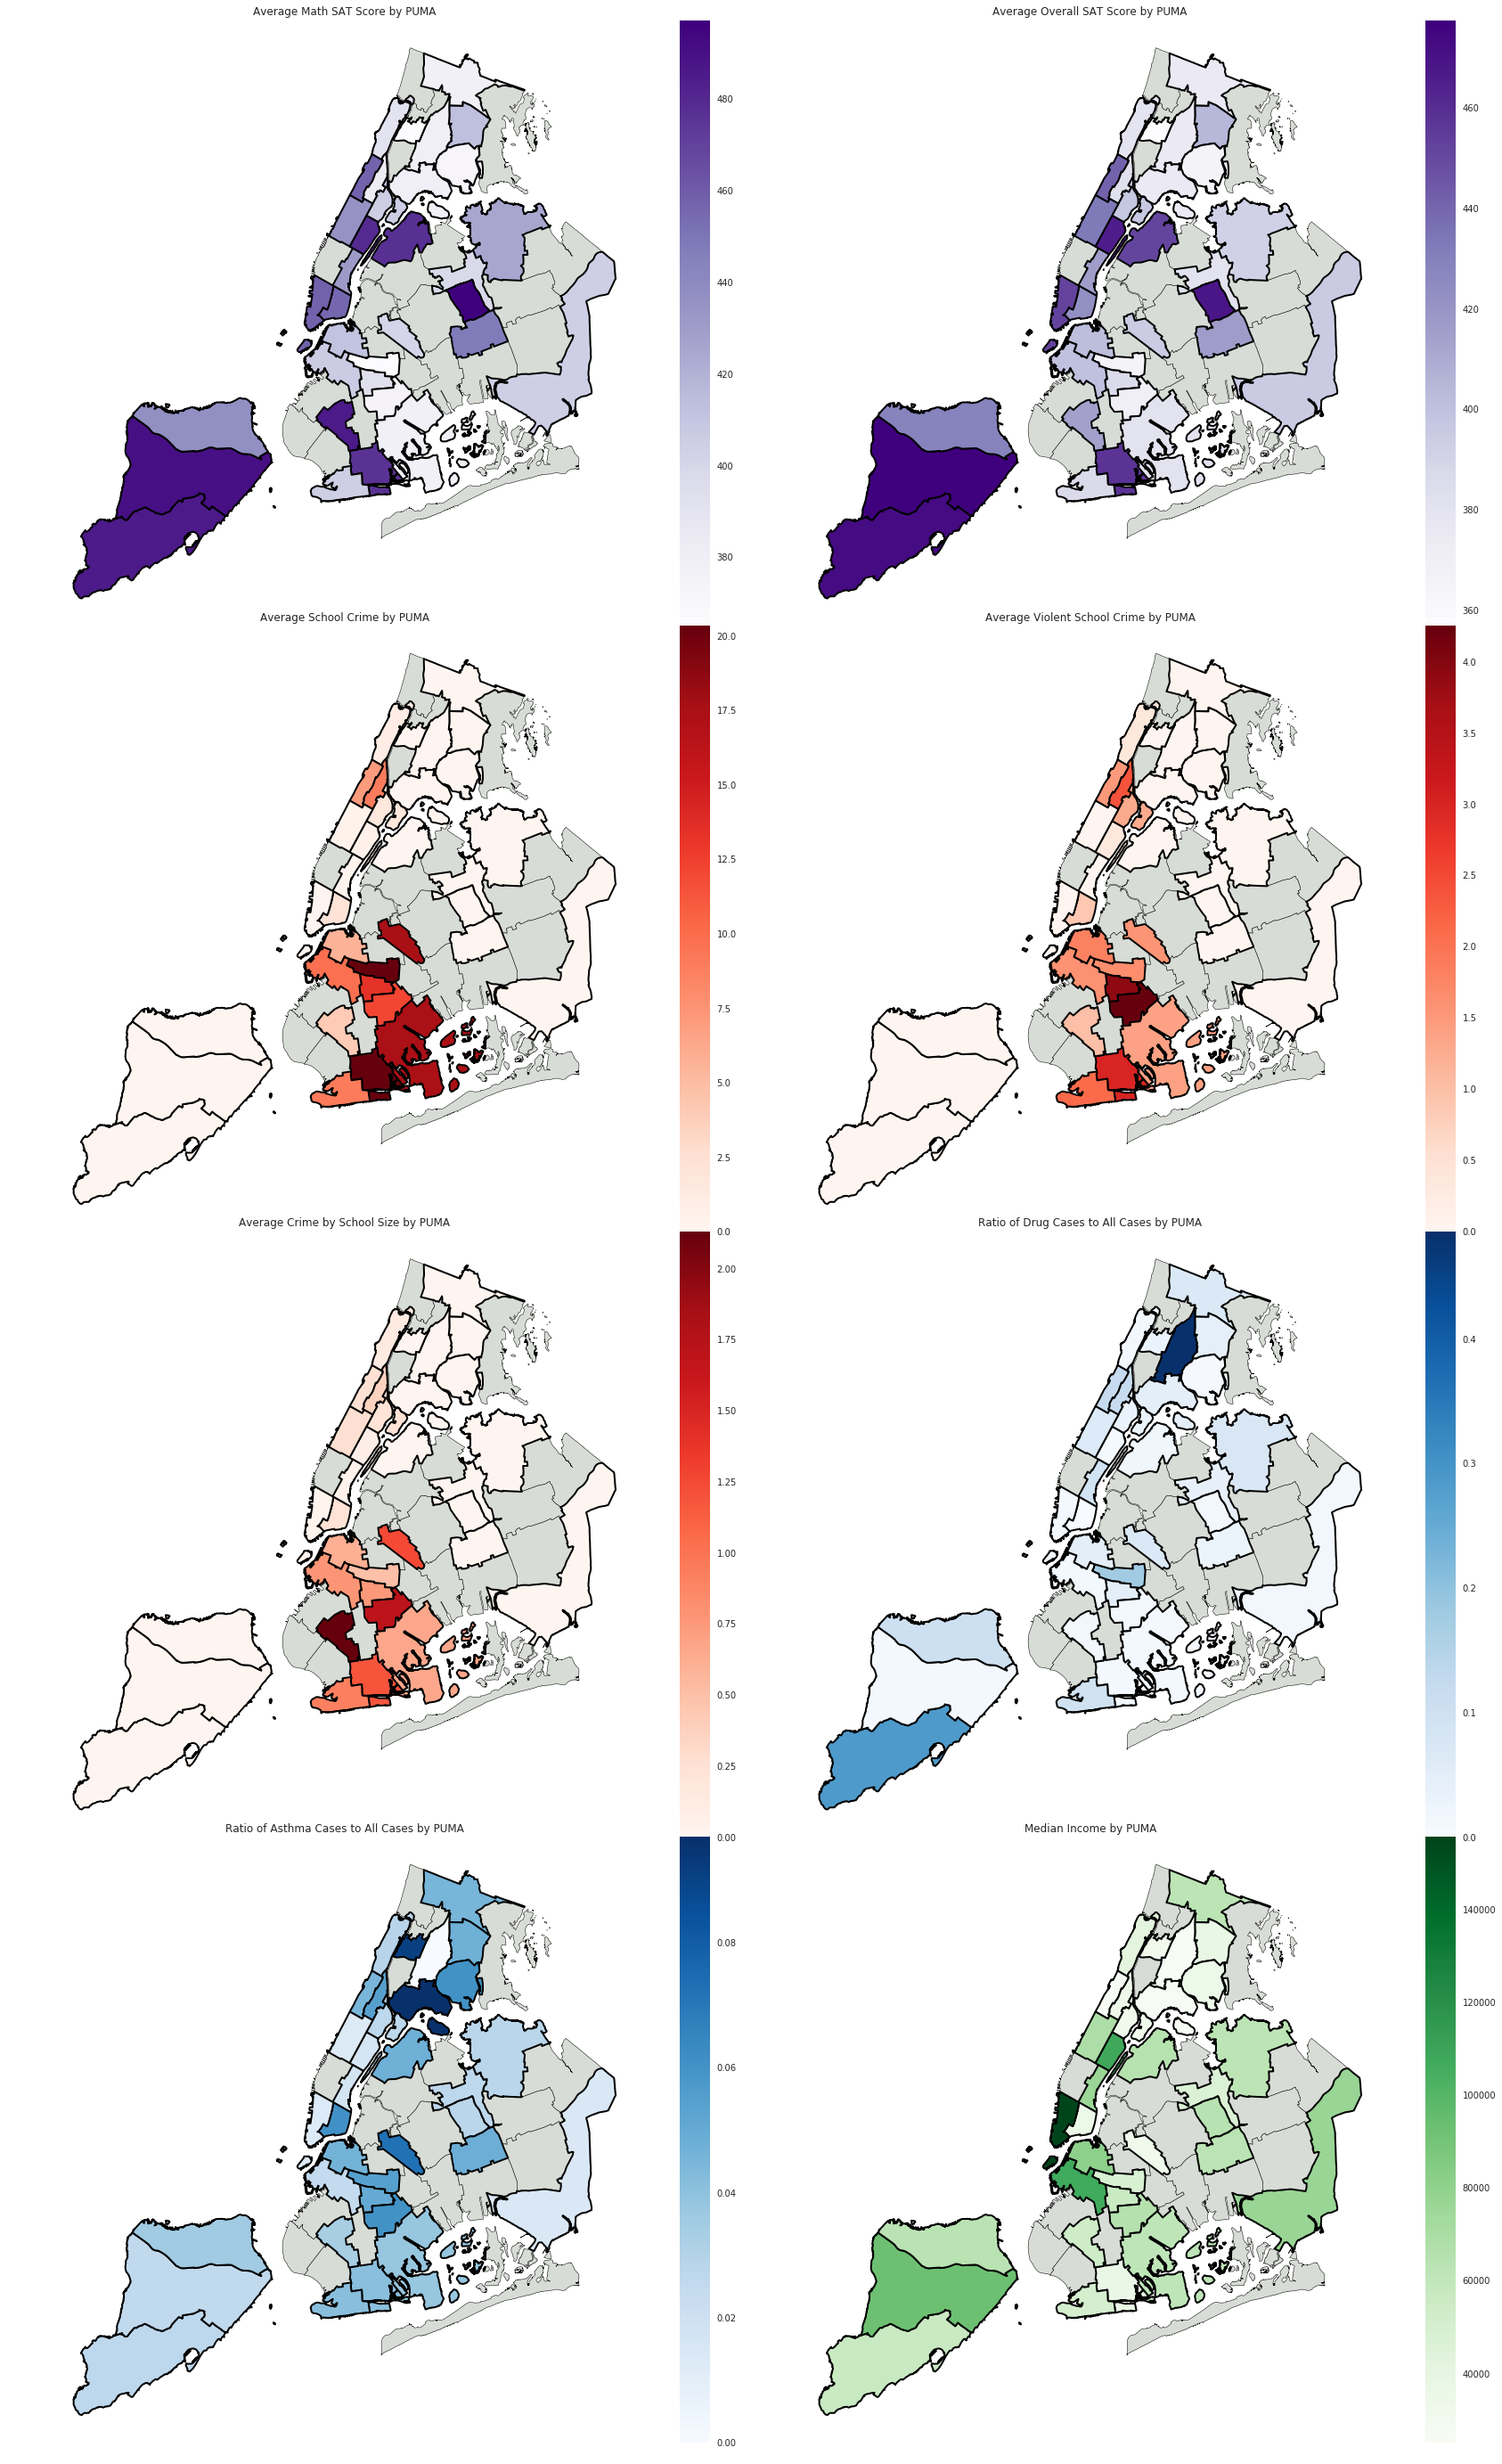

In [80]:
# plot with various axes scales
fix = plt.figure(1, figsize=(30,50))

# math sat
ax1 = plt.subplot(421)
#ax1.set_aspect('equal')
ax1.axis('off')
plt.title("Average Math SAT Score by PUMA", fontsize='large')
puma_shapes.plot(ax=ax1, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax1, cmap='Purples', column='sat_math_avg_score', edgecolor='black', lw=2, legend=True)

# overall sat
ax2 = plt.subplot(422)
#ax2.set_aspect('equal')
ax2.axis('off')
plt.title("Average Overall SAT Score by PUMA", fontsize='large')
puma_shapes.plot(ax=ax2, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax2, cmap='Purples', column='overall_avg', edgecolor='black', lw=2, legend=True)

# total crime
ax3 = plt.subplot(423)
#ax3.set_aspect('equal')
ax3.axis('off')
plt.title("Average School Crime by PUMA", fontsize='large')
puma_shapes.plot(ax=ax3, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax3, cmap='Reds', column='nocrim_n', edgecolor='black', lw=2, legend=True)

# violent crime
ax4 = plt.subplot(424)
#ax4.set_aspect('equal')
ax4.axis('off')
plt.title("Average Violent School Crime by PUMA", fontsize='large')
puma_shapes.plot(ax=ax4, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax4, cmap='Reds', column='vio_n', edgecolor='black', lw=2, legend=True)

# avg size crime
ax5 = plt.subplot(425)
#ax5.set_aspect('equal')
ax5.axis('off')
plt.title("Average Crime by School Size by PUMA", fontsize='large')
puma_shapes.plot(ax=ax5, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax5, cmap='Reds', column='avgofmajor_n', edgecolor='black', lw=2, legend=True)

# drug
ax6 = plt.subplot(426)
#ax6.set_aspect('equal')
ax6.axis('off')
plt.title("Ratio of Drug Cases to All Cases by PUMA", fontsize='large')
puma_shapes.plot(ax=ax6, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax6, cmap='Blues', column='drug_ratio', edgecolor='black', lw=2, legend=True)

# asthma
ax7 = plt.subplot(427)
#ax7.set_aspect('equal')
ax7.axis('off')
plt.title("Ratio of Asthma Cases to All Cases by PUMA", fontsize='large')
puma_shapes.plot(ax=ax7, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax7, cmap='Blues', column='asthma_ratio', edgecolor='black', lw=2, legend=True)

# income
ax8 = plt.subplot(428)
#ax8.set_aspect('equal')
ax8.axis('off')
plt.title("Median Income by PUMA", fontsize='large')
puma_shapes.plot(ax=ax8, color='xkcd:light grey', edgecolor='black', lw=0.5)
final_data_g.plot(ax=ax8, cmap='Greens', column='median_income', edgecolor='black', lw=2, legend=True)


plt.subplots_adjust(hspace=0, wspace=0)

plt.show()

Figure showing 8 different choropleth maps of New York City PUMAs shaded by features about education (purple), crime (red), health (blue), and income (green).

## 8. Linear Models

#### 8.1 Create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature.

In [81]:
#whiten the data
numeric_cols = list(final_data.columns.values)
numeric_cols.remove('puma')

final_data[numeric_cols] = pd.DataFrame(columns=numeric_cols, 
                                        data=preprocessing.scale(final_data[numeric_cols]))

final_data.drop(axis=1, labels=['puma'], inplace=True)

In [82]:
final_data.head()

,avgofmajor_n,avgofnocrim_n,avgofoth_n,avgofprop_n,avgofvio_n,major_n,nocrim_n,oth_n,prop_n,vio_n,sat_math_avg_score,overall_avg,asthma_flag,drug_flag,all_flag,asthma_ratio,drug_ratio,median_income
0,-0.674058,-0.655976,-0.667706,-0.660691,-0.671760,-0.667058,-0.683364,-0.801554,-0.770282,-0.730197,-1.063302,-0.976467,0.438022,0.207686,-0.016858,0.270172,0.033696,0.155562
1,-0.674058,-0.655976,-0.667706,-0.660691,-0.671760,-0.667058,-0.683364,-0.801554,-0.770282,-0.730197,-0.227746,-0.109742,2.426484,0.484918,1.114588,0.353135,-0.229120,-0.762749
2,1.557386,1.429033,1.574458,1.611714,1.474429,0.899041,2.427304,1.807234,1.428930,1.832354,1.323610,1.439402,-0.604570,-0.632712,-0.602517,0.055588,-0.589257,-0.784609
3,-0.674058,-0.655976,-0.667706,-0.660691,-0.671760,-0.667058,-0.683364,-0.801554,-0.770282,-0.730197,-1.050531,-0.972293,-1.388399,0.286007,-0.962140,-1.897836,4.527979,-1.205555
4,-0.674058,-0.655976,-0.667706,-0.660691,-0.671760,-0.667058,-0.683364,-0.801554,-0.770282,-0.730197,-1.395347,-1.496073,-0.583216,-0.606605,-0.887780,2.422581,-0.349799,-0.976920


In [83]:
m1 = smf.ols(formula='overall_avg~avgofmajor_n+avgofnocrim_n+avgofoth_n+avgofvio_n+ \
+major_n+nocrim_n+oth_n+prop_n+vio_n', data=final_data).fit()

In [84]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            overall_avg   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                 -0.146
Method:                 Least Squares   F-statistic:                    0.5324
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.837
Time:                        21:54:36   Log-Likelihood:                -45.150
No. Observations:                  34   AIC:                             110.3
Df Residuals:                      24   BIC:                             125.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept              0      0.186          0      1.000        -0.385     0.385
avgofmajor_n      0.8819      1.684      0.524      0.605        -2.593     4.357
avgofnocrim_n     0.3950      1.565      0.252      0.803        -2.835     3.625
avgofoth_n       -0.5499      3.931     -0.140      0.890        -8.663     7.563
avgofvio_n       -0.8417      3.677     -0.229      0.821        -8.431     6.747
major_n          -0.4691      0.760     -0.617      0.543        -2.039     1.100
nocrim_n          0.1169      0.492      0.237      0.814        -0.900     1.133
oth_n             0.9384      1.050      0.894      0.380        -1.228     3.105
prop_n           -0.6612      1.018     -0.649      0.522        -2.763     1.440
vio_n            -0.0877      0.627     -0.140      0.890        -1.382     1.207
==============================================================================
Omnibus:                        1.656   Durbin-Watson:                   1.237
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.469
Skew:                           0.378   Prob(JB):                        0.480
Kurtosis:                       2.318   Cond. No.                         77.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Discussion:** This is not a very good model because we gave it 10 fairly co-linear features to consider.  The $R^2$ value, which measures how well the line approximates the data, is quite low.  The Omnibus is high, which indicates that the probability that the residuals are normally distributed is low.  The condition number is also very high, which is an indication of multi co-linearity (which we already knew).

#### 8.2 Add drugs and asthma discharge data and create a new multilinear model

In [85]:
m2 = smf.ols(formula='overall_avg~avgofmajor_n+avgofnocrim_n+avgofoth_n+avgofvio_n+ \
+major_n+nocrim_n+oth_n+prop_n+vio_n+drug_ratio+asthma_ratio', data=final_data).fit()

In [86]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            overall_avg   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.9851
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.488
Time:                        21:54:36   Log-Likelihood:                -41.435
No. Observations:                  34   AIC:                             106.9
Df Residuals:                      22   BIC:                             125.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept              0      0.175          0      1.000        -0.362     0.362
avgofmajor_n      0.5987      1.596      0.375      0.711        -2.711     3.908
avgofnocrim_n     1.0985      1.502      0.731      0.472        -2.017     4.214
avgofoth_n       -0.2024      3.729     -0.054      0.957        -7.937     7.532
avgofvio_n       -1.6288      3.498     -0.466      0.646        -8.883     5.626
major_n          -0.1339      0.743     -0.180      0.859        -1.674     1.406
nocrim_n          0.1029      0.463      0.222      0.826        -0.857     1.063
oth_n             1.0648      0.987      1.078      0.293        -0.983     3.112
prop_n           -0.9251      0.969     -0.954      0.350        -2.936     1.085
vio_n            -0.1245      0.590     -0.211      0.835        -1.348     1.099
drug_ratio       -0.2235      0.194     -1.154      0.261        -0.625     0.178
asthma_ratio     -0.4406      0.195     -2.265      0.034        -0.844    -0.037
==============================================================================
Omnibus:                        1.873   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.671
Skew:                           0.514   Prob(JB):                        0.434
Kurtosis:                       2.652   Cond. No.                         79.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Extra credit: if you have income add income data and create a new multilinear model

In [87]:
m3 = smf.ols(formula='overall_avg~avgofmajor_n+avgofnocrim_n+avgofoth_n+avgofvio_n+ \
+major_n+nocrim_n+oth_n+prop_n+vio_n+drug_ratio+asthma_ratio+median_income', data=final_data).fit()

In [88]:
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            overall_avg   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     1.310
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.284
Time:                        21:54:36   Log-Likelihood:                -38.743
No. Observations:                  34   AIC:                             103.5
Df Residuals:                      21   BIC:                             123.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept              0      0.165          0      1.000        -0.343     0.343
avgofmajor_n      0.4712      1.511      0.312      0.758        -2.670     3.612
avgofnocrim_n     1.2609      1.423      0.886      0.386        -1.698     4.220
avgofoth_n       -0.5160      3.531     -0.146      0.885        -7.858     6.826
avgofvio_n       -1.3449      3.311     -0.406      0.689        -8.231     5.541
major_n          -0.4338      0.720     -0.603      0.553        -1.931     1.063
nocrim_n          0.2105      0.441      0.477      0.638        -0.708     1.129
oth_n             1.4241      0.953      1.495      0.150        -0.557     3.405
prop_n           -1.2325      0.931     -1.324      0.200        -3.168     0.703
vio_n            -0.0076      0.561     -0.014      0.989        -1.175     1.160
drug_ratio        0.0166      0.223      0.075      0.941        -0.446     0.479
asthma_ratio     -0.1292      0.246     -0.524      0.606        -0.642     0.383
median_income     0.4710      0.248      1.898      0.072        -0.045     0.987
==============================================================================
Omnibus:                        3.144   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.869
Skew:                           0.661   Prob(JB):                        0.238
Kurtosis:                       2.473   Cond. No.                         79.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 9. Compare the linear models

Since these linear models are nested, I am going to use the likelihood-ratio test to evaluate the hypothesis that the model m3 that includes health and income data along with crime data tells us more about the SAT scores in the PUMA than the model m1 that only includes the crime data.

Null hypothesis: Model m3 with additional features does NOT tell us more about SAT scores than model m1.
Alternate hypothsis: Model m3 DOES tell us more about SAT scores than model m1.

Confidence level:
$\\alpha=0.05$

In [89]:
lr_stat, p_value, df_dff = m3.compare_lr_test(m1)

In [90]:
print("p-value:", p_value)

p-value: 0.00506114860778


The p-value for my likelhood ratio is less than the confidence level of 0.05 I set, and thus I can reject the null hypothesis that a model with the additional features on health and income do not tell us more about SAT scores in a PUMA than the model without them.

## 10. Random Forest Regression on school-related data only

#### 10.1 Create a random forest model using only the crime in school data, but using all 10 crime in school features.

In [91]:
crime_cols = [col for col in crime_cols if col not in ('sat_math_avg_score','overall_avg')]

In [92]:
print(crime_cols)

['avgofmajor_n', 'avgofnocrim_n', 'avgofoth_n', 'avgofprop_n', 'avgofvio_n', 'major_n', 'nocrim_n', 'oth_n', 'prop_n', 'vio_n']


In [93]:
x = final_data[crime_cols]
y = final_data.overall_avg

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state = 42)

In [95]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17, 10), (17, 10), (17,), (17,))

In [96]:
rf = rfr(n_estimators = 100, random_state = 42)

In [97]:
rf1_fit = rf.fit(x_train, y_train)

In [98]:
rf.score(x_train, y_train)

0.3767802848044971

In [99]:
rf.score(x_test, y_test)

-0.50829495393821356

In [100]:
predictions = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.9


Text(0,0.5,'y_test')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


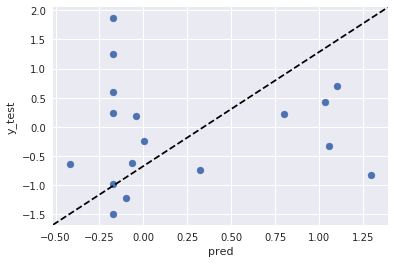

In [101]:
plt.scatter(predictions, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

Figure showing the model-predicted SAT score versus the acutal SAT score.  This model is overfitting the data--it scores much more highly on the training data than the test data.  

#### 10.2 Measure the feature importance of the features in this model to select the 3 most predictive features.

In [102]:
print(rf.feature_importances_)

[ 0.15222884  0.1067645   0.09743641  0.12531753  0.10523534  0.08299834
  0.08864897  0.11410727  0.06838739  0.0588754 ]


In [103]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    plt.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    plt.xlim([-1, indices.shape[0]])
    plt.show()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


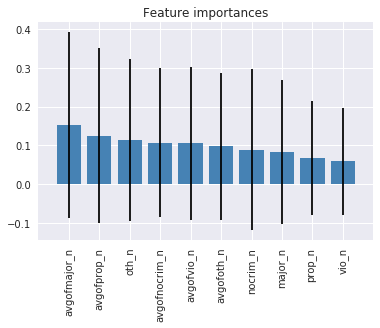

In [104]:
featureImportancePlot(rf, crime_cols)

## 11. Random forest with crime and medical (and income if you have it) features

#### 11.1 Create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income if you have it from the EC)

In [105]:
features = ['avgofmajor_n','avgofprop_n','oth_n','drug_ratio','asthma_ratio','median_income']

In [106]:
x = final_data[features]
y = final_data.overall_avg

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state = 42)

In [108]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17, 6), (17, 6), (17,), (17,))

In [109]:
rf2_fit = rf.fit(x_train, y_train)

#### 11.2 Evaluate the performance of the model.

In [110]:
rf.score(x_train, y_train)

0.84864900091950024

In [111]:
rf.score(x_test, y_test)

-0.13403317320322894

In [112]:
predictions = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.77


Text(0,0.5,'y_test')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


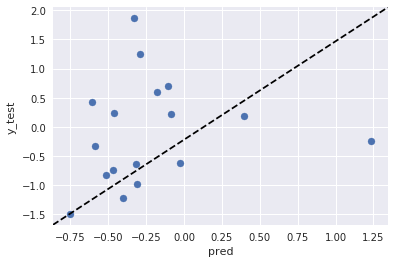

In [113]:
plt.scatter(predictions, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

Figure showing the actual SAT value versus the model-predicted SAT value. This model is also overfitting but not as badly as the last one!

#### 11.3 Discuss the importance of each feature in the model.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


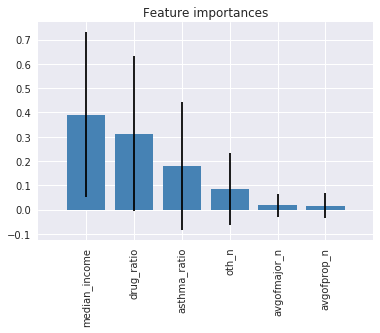

In [114]:
featureImportancePlot(rf, features)

Median income is the most important feature in the model, followed by the ratio of drug diagnoses to all diagnoses in the PUMA, and the ratio of asthma diagnoses to all diagnoses in the PUMA.